# Assignment 1
## Problem 6 - Normalizing Flows

In [26]:
%reload_ext autoreload
%autoreload 2

import sys
SRC_PATH = ["/Users/thomas/Code/22w_nlsp", "/home/fritz/Documents/NLSP/nlsp_ue/"]

if any(map(lambda p: p not in sys.path, SRC_PATH)):
    sys.path.extend(SRC_PATH)
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import torch
from matplotlib import cm
from src.utils.io import load_image, img_to_bw

from src.utils.plotting import init_plot_style, show_grayscale_img
# %pylab

init_plot_style()
data_dir='../../data/img/'

If necessary, we first have to convert our grayscale icons to a binary image.

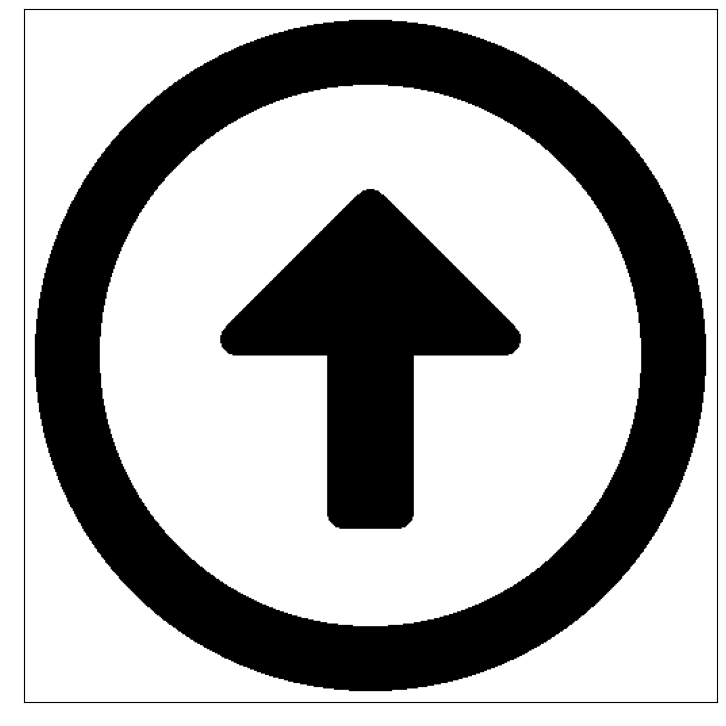

In [27]:
img = img_to_bw(data_dir + 'up.png', data_dir + 'up_bw.png')
show_grayscale_img(img)

Now we can load the binary image and generate samples from it as described in the assignment sheet.

Our image format is 512 x 512.


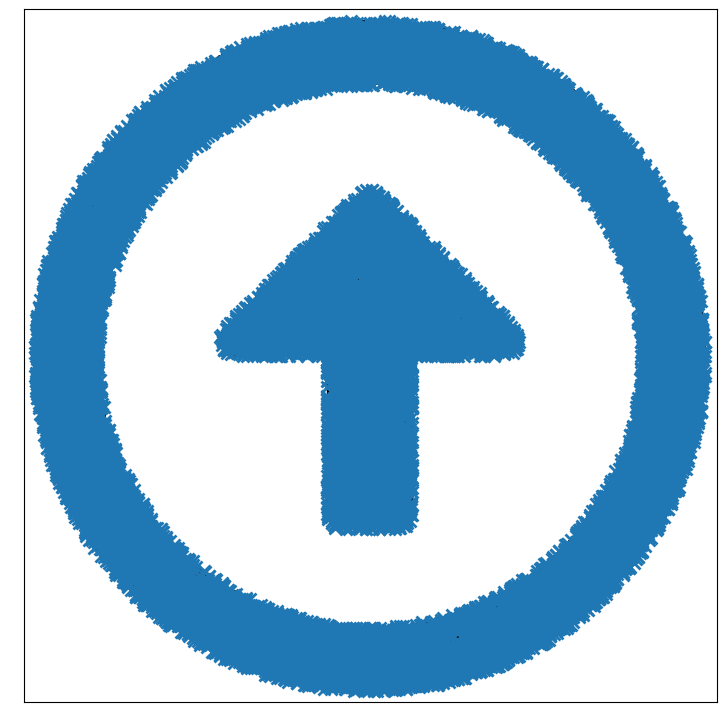

In [34]:
# load image
img = load_image(data_dir + 'up_bw.png')
height, width = img.shape
print(f'Our image format is {width} x {height}.')

# generate training samples
n_samples = 20000 # number of samples to generate
data = np.zeros((n_samples, 2))
rng = np.random.default_rng(seed=0)
i=0
while i < n_samples:
    row = rng.integers(0, height)
    col = rng.integers(0, width)
    if img[row, col] == 0:
        data[i,0] = col
        data[i,1] = row
        i += 1

# plot image with generated samples
show_grayscale_img(img)
plt.plot(data[:,0], data[:,1], 'x')
plt.xlim([0, width])
plt.ylim([0, height])
data = data.astype(np.float64) / 512

Train your flow here.

In [35]:
base_dist = dist.Normal(torch.Tensor([0.5,0.5]), torch.ones(2))
num_components = 2
transforms = [dist.transforms.spline_coupling(2, count_bins=32, bound=3) for _ in range(num_components)]
#dist.transforms.spline_coupling()
flow_dist = dist.TransformedDistribution(base_dist, transforms)
data = torch.Tensor(data)
# sample training data from the true distribution
num_samples = 5000
#data = px.sample(torch.Size([num_samples,])).detach()

# configure optimizier
modules = torch.nn.ModuleList(transforms)
optimizer = torch.optim.Adam(modules.parameters(), lr=5e-2)
print(flow_dist)
# start training
steps = 800
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(data).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

TransformedDistribution()
step: 0, loss: 2.190833330154419
step: 100, loss: -0.6192589402198792


Put your learned model to the test: generate and plot some test samples.

TransformedDistribution()
2138.246
-1675.3588


<Figure size 1000x1000 with 0 Axes>

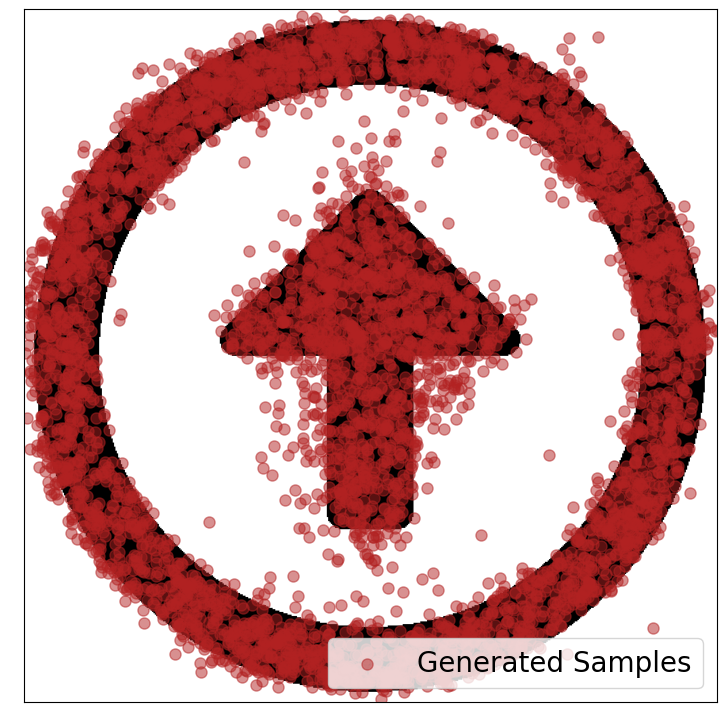

In [30]:
# generate samples from the learned distribution
print(flow_dist)
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy() * 512
print(np.max(samples))
print(np.min(samples))

plt.close('all')
plt.figure(figsize=(10,10))
show_grayscale_img(img)
plt.scatter(samples[:,0], samples[:,1], color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0, width])
plt.ylim([0, height])
plt.legend()

We also want to have a look at the log-likelihood of our model!

Text(0.5, 1.0, 'Log-Likelihood')

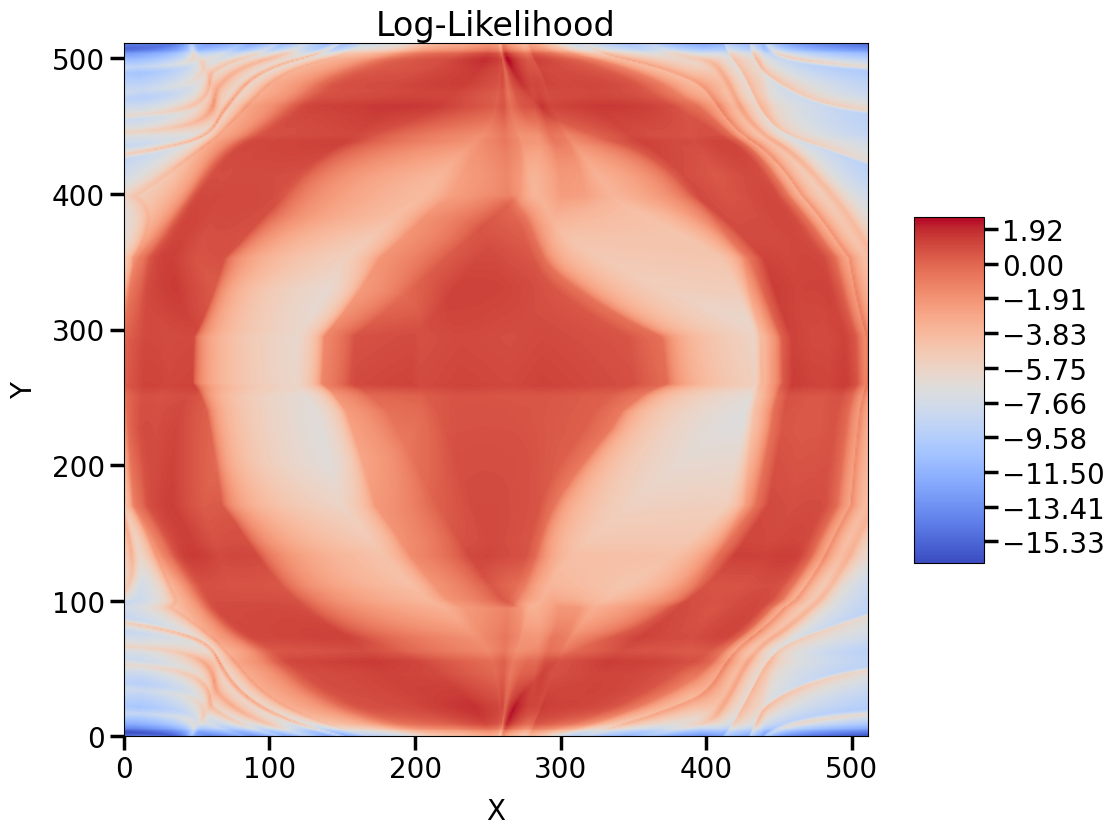

In [31]:
# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)
X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob(coordinates/width).detach().view(-1,width).numpy()
zmin = log_likelihood.min().item()
zmax = log_likelihood.max().item()
levels = torch.linspace(zmin, zmax, 1000).numpy()
# finally, let's plot the log-likelihood
fig, ax = plt.subplots()
surf = ax.contourf(X, Y, log_likelihood, cmap=cm.coolwarm, levels=levels, vmin=zmin, vmax=zmax)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# surf = ax.plot_surface(X, Y, log_likelihood, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# surf = ax.contourf3D(X, Y, log_likelihood, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# ax.zaxis.set_major_formatter('{x:.02f}')
# ax.view_init(azim=-90, elev=90) # bird's eye view
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Log-Likelihood')


In [7]:
plt.show()

2.6105595